In [29]:
import pickle
from joblib import load
from UTILS import *
from CL_Split import test_df as data
import time
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
time_map={}

In [31]:
data['Order Date']=pd.to_datetime(data['Order Date'])
data['Order year']=data['Order Date'].dt.year
data['Order quarter']=data['Order Date'].dt.quarter
data = data.drop('Order Date', axis=1)
data['Ship Date']=pd.to_datetime(data['Ship Date'])
data['Ship year']=data['Ship Date'].dt.year
data['Ship quarter']=data['Ship Date'].dt.quarter
data = data.drop('Ship Date', axis=1)
#Extract Categories
data[["Main Category","Sub Category"]]=data["CategoryTree"].str.extract("'MainCategory': '(?P<Main_Category>[^']*)', 'SubCategory': '(?P<Sub_Category>[^']*)'")
data.drop(columns=['CategoryTree'],inplace=True)
#Drop Features
data.drop(columns=["Row ID","Order ID","Customer ID","City","Postal Code","Ship year","Ship quarter","Product Name","Country","Segment"],inplace=True)


In [32]:
data["Region"].iloc[1]=np.nan
data["Main Category"].iloc[3]=np.nan
data["Region"].iloc[2]="7mada"
data["Main Category"].iloc[3]="Zomba"

C:\Users\tote_\AppData\Local\Temp\ipykernel_6264\1031428008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Region"].iloc[1]=np.nan
C:\Users\tote_\AppData\Local\Temp\ipykernel_6264\1031428008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Main Category"].iloc[3]=np.nan
C:\Users\tote_\AppData\Local\Temp\ipykernel_6264\1031428008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Region"].iloc[2]="7mada"
C:\Us

In [33]:
preprocess_dict=load("[CL]preprocessing_opt1.joblib")
model=load("[CL]model_opt1.joblib")

In [34]:
# Use the loaded dictionary to transform names in new data
data["state_mean"] = data["State"].map(preprocess_dict["map_state"])
data["sub_cat_encoded"] = data["Sub Category"].map(preprocess_dict["map_sub_cat"])
data["ReturnCategoryNominal"]=data["ReturnCategory"].map(preprocess_dict["map_target"])

In [35]:
one_hot_df=data[["Main Category","Region"]]
encoder=model["Onehot_scaler"]
final_cat_df=pd.DataFrame(encoder.transform(one_hot_df),columns=encoder.get_feature_names_out(one_hot_df.columns),index=data.index)

In [36]:
final_df=pd.concat([data,final_cat_df],axis=1)
final_df=final_df[preprocess_dict["Columns"]]

In [37]:
final_df.columns

Index(['Sales', 'Quantity', 'Discount', 'ReturnCategoryNominal', 'state_mean',
       'sub_cat_encoded', 'Main Category_Furniture',
       'Main Category_Office Supplies', 'Main Category_Technology',
       'Region_Central', 'Region_East', 'Region_South', 'Region_West'],
      dtype='object')

In [38]:
data["ReturnCategoryNominal"]

5487    2
2577    3
3692    2
5918    3
7562    3
       ..
1079    3
6573    2
1115    3
4747    3
6733    3
Name: ReturnCategoryNominal, Length: 1599, dtype: int64

In [39]:
final_df_filled=fill_missing(final_df.drop(columns=["ReturnCategoryNominal"]),preprocess_dict["missing_values"])

In [40]:
X=final_df_filled
X=pd.DataFrame(model["Scaler"].transform(X),columns=X.columns)
y=final_df["ReturnCategoryNominal"]

<h3>SVM Classifier</h3>

Accuracy: 0.7848655409631019 ,
 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.55      0.64        42
           1       0.86      0.75      0.80       248
           2       0.76      0.88      0.81       572
           3       0.78      0.75      0.77       598
           4       0.81      0.66      0.73       139

    accuracy                           0.78      1599
   macro avg       0.80      0.72      0.75      1599
weighted avg       0.79      0.78      0.78      1599



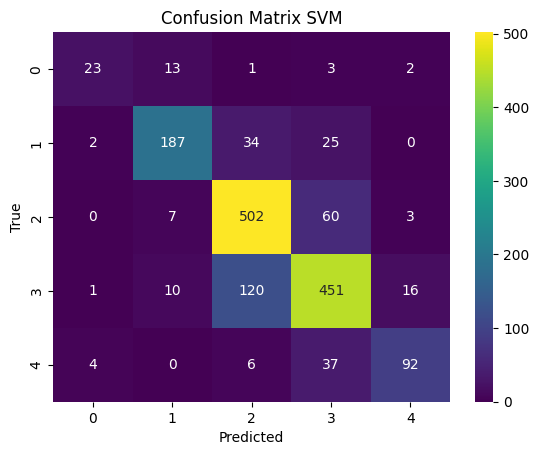

In [41]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
start=time.time()
y_pred=model["Model"]["svc"].predict(X)
time_map["svm"]=time.time()-start
acc_svc=accuracy_score(y,y_pred)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix SVM')
    

print(f'Accuracy: {acc_svc} ,\n Classification Report:\n {classification_report(y,y_pred)}')


Accuracy: 0.7392120075046904 ,
 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.38      0.52        42
           1       0.85      0.69      0.76       248
           2       0.71      0.86      0.78       572
           3       0.71      0.69      0.70       598
           4       0.81      0.66      0.73       139

    accuracy                           0.74      1599
   macro avg       0.79      0.66      0.70      1599
weighted avg       0.75      0.74      0.74      1599



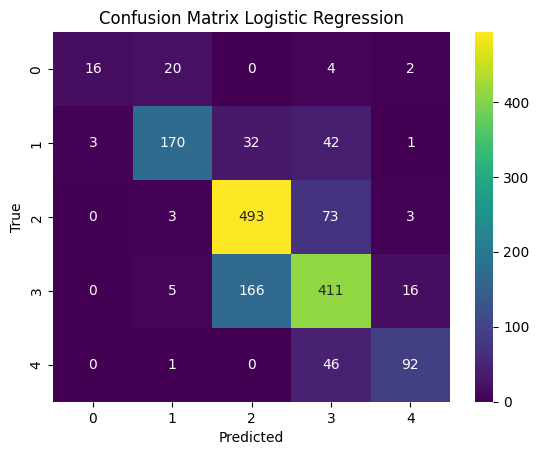

In [42]:
start=time.time()
y_pred=model["Model"]["lgreg"].predict(X)
time_map["lgreg"]=time.time()-start
acc_svc=accuracy_score(y,y_pred)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Logistic Regression')

print(f'Accuracy: {acc_svc} ,\n Classification Report:\n {classification_report(y,y_pred)}')

Accuracy: 0.8624140087554721 ,
 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.71      0.75        42
           1       0.81      0.79      0.80       248
           2       0.88      0.89      0.89       572
           3       0.88      0.87      0.87       598
           4       0.84      0.88      0.86       139

    accuracy                           0.86      1599
   macro avg       0.84      0.83      0.83      1599
weighted avg       0.86      0.86      0.86      1599



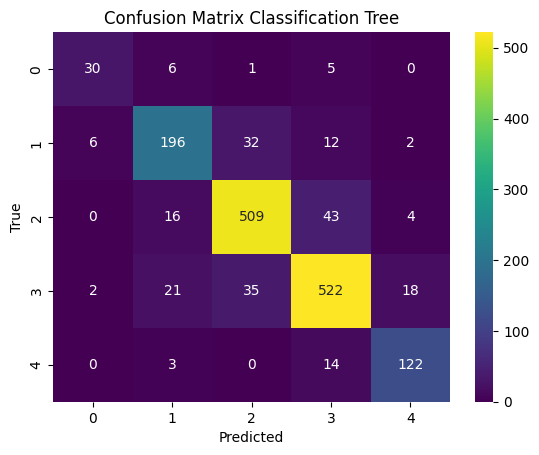

In [43]:
start=time.time()
y_pred=model["Model"]["tree"].predict(X)
time_map["tree"]=time.time()-start
acc_svc=accuracy_score(y,y_pred)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Classification Tree')

print(f'Accuracy: {acc_svc} ,\n Classification Report:\n {classification_report(y,y_pred)}')

Accuracy: 0.8530331457160726 ,
 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.67      0.76        42
           1       0.85      0.78      0.82       248
           2       0.90      0.86      0.88       572
           3       0.82      0.90      0.86       598
           4       0.84      0.78      0.81       139

    accuracy                           0.85      1599
   macro avg       0.86      0.80      0.82      1599
weighted avg       0.86      0.85      0.85      1599



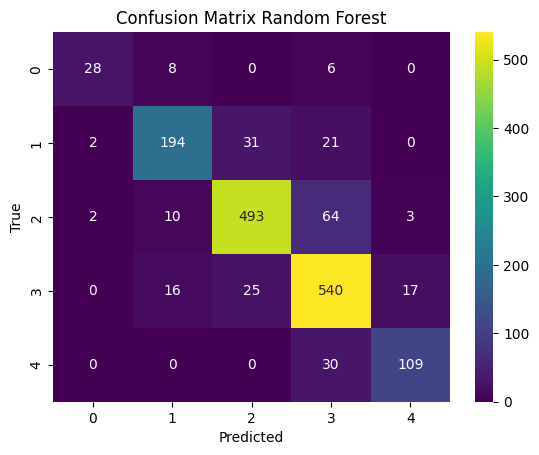

In [44]:
start=time.time()
y_pred=model["Model"]["rf"].predict(X)
time_map["rf"]=time.time()-start
acc_rf=accuracy_score(y,y_pred)
sns.heatmap(confusion_matrix(y,y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Random Forest')

print(f'Accuracy: {acc_rf} ,\n Classification Report:\n {classification_report(y,y_pred)}')

Text(0.5, 1.0, 'Time Taken in test')

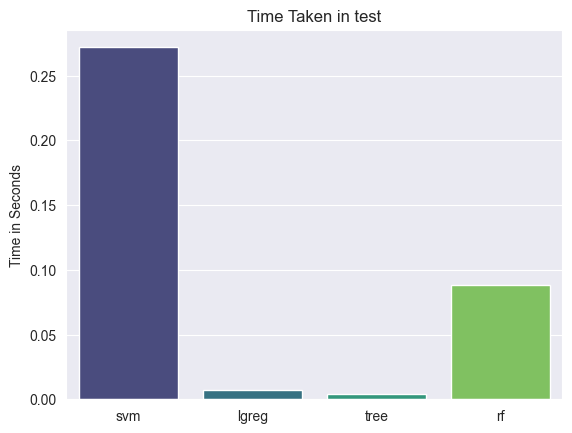

In [45]:
plt.figure()
sns.set_style("darkgrid")
plt.rcParams["figure.facecolor"] = "lightgray"

sns.barplot(x=list(time_map.keys()),y=list(time_map.values()),palette="viridis")
plt.ylabel("Time in Seconds")
plt.title("Time Taken in test")